In [1]:
import numpy as np
import math, random

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F

from geometry.model import Model, combine_observations, get_mesh
from geometry.utils.visualisation import illustrate_points, illustrate_mesh, illustrate_voxels
from geometry.voxel_grid import VoxelGrid

from rl.environment import Environment, CombiningObservationsWrapper
from rl.environment import StepPenaltyRewardWrapper, DepthMapWrapper
from rl.environment import VoxelGridWrapper, VoxelWrapper, FrameStackWrapper

from rl.dqn import CnnDQN, CnnDQNA, VoxelDQN
from rl.utils import DiskReplayBuffer, ReplayBuffer


# !conda install -c conda-forge pyembree
# !conda install -c conda-forge igl
# !pip install Cython
# !pip install gym

In [2]:
def plot(frame_idx, rewards, novps, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('number of vp: %s' % np.mean(novps[-10:]))
    plt.plot(novps)
    plt.subplot(133)
    plt.title('loss')
    if len(losses) > 20:
        plt.plot(losses[20:])
    else:
        plt.plot(losses)
    plt.show()

## DQN

In [3]:
USE_CUDA = torch.cuda.is_available()

if USE_CUDA:
    torch.cuda.set_device(1)
    print(torch.cuda.current_device())

In [4]:
import gym

class ActionMaskWrapper(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        self.mask = None
        
    def reset(self, **kwargs):
        observation, action = self.env.reset(**kwargs)
        self.mask = np.ones(self.number_of_view_points).astype(bool)
        self.mask[action] = False
        return observation, action, self.mask
    
    def step(self, action):
        observation, reward, done, info = self.env.step(action)
        
        done = done or self.done()
        return observation, reward, done, info, self.mask

    def done(self):
        return np.count_nonzero(self.mask) == len(self.mask)

    def render(self, action, observation):
        self.env.render(action, observation)

    def final_reward(self):
        return self.env.final_reward()

In [5]:
env = Environment(illustrate=False, model_path="./data/Pyramid.obj", number_of_view_points=100)
# env = CombiningObservationsWrapper(env)
# env = StepPenaltyRewardWrapper(env, weight=1.0)
# env = DepthMapWrapper(env)

env = VoxelGridWrapper(env)
env = CombiningObservationsWrapper(env)
env = VoxelWrapper(env)
env = StepPenaltyRewardWrapper(env)
env = FrameStackWrapper(env, num_stack=4, lz4_compress=False)
env = ActionMaskWrapper(env)

In [6]:
class VoxelDQN(nn.Module):
    def __init__(self, input_shape, num_actions, gamma=0.99, learning_rate=0.001):
        super().__init__()

        self.input_shape = input_shape
        self.num_actions = num_actions
        self.gamma = gamma

        self.features = nn.Sequential(
            nn.Conv2d(input_shape[0], 64, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1),
            nn.ReLU()
        )

        self.fc = nn.Sequential(
            nn.Linear(self.feature_size(), 128),
            nn.ReLU(),
            nn.Linear(128, self.num_actions)
        )

        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    def feature_size(self):
        return self.features(autograd.Variable(torch.zeros(1, *self.input_shape))).view(1, -1).size(1)

    def act(self, state, mask, epsilon):
        if random.random() > epsilon:
            state   = Variable(torch.FloatTensor(np.float32(state)).unsqueeze(0), volatile=True)
            q_value = self.forward(state)
            q_value *= mask
            action  = q_value.max(1)[1].item()
            print("Action: ", action)
        else:
            action = np.random.choice(np.arange(self.num_actions)[mask])
            print("Action: ", action, "(random)")
        return action

    def compute_td_loss(self, state, action, reward, next_state, done, mask):
        q_values      = self.forward(state)
        next_q_values = self.forward(next_state)
        next_q_values *= mask

        q_value          = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
        next_q_value     = next_q_values.max(1)[0]
        expected_q_value = reward + self.gamma * next_q_value * (1 - done)

        loss = torch.mean((q_value - expected_q_value.detach()) ** 2)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss


In [7]:
from rl.dqn import CnnDQN, CnnDQNA

model = VoxelDQN(env.observation_space.shape, env.action_space.n)

if USE_CUDA:
    model = model.cuda()

replay_initial = 10
replay_buffer = DiskReplayBuffer(capacity=100000,
                                 overwrite=True,
                                 num_actions=env.action_space.n,
                                 observation_dtype=env.observation_space.dtype,
                                 observation_shape=env.observation_space.shape)

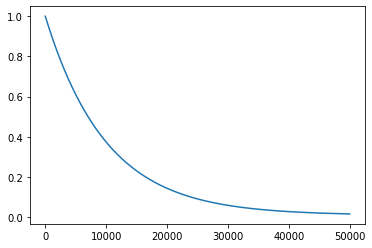

In [8]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 10000

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * \
        math.exp(-1. * frame_idx / epsilon_decay)

plt.plot([epsilon_by_frame(i) for i in range(50000)])

### Training

In [9]:
num_frames = 100000
batch_size = 2
save_model_path = "./models/abc-vdqn-{}.pt"


losses = []
all_rewards = []
all_nofs = []
episode_reward = 0

state, _, mask = env.reset()
nof_vp = 0
for frame_idx in range(1, num_frames + 1):
    epsilon = epsilon_by_frame(frame_idx)
    action = model.act(state, mask, epsilon)

    next_state, reward, done, _, mask = env.step(action)
    replay_buffer.push(state, action, reward, next_state, done, mask)

    state = next_state
    episode_reward += reward
    nof_vp += 1

    # env.render(action, state)

    if done:
        # final_reward = env.final_reward()
        # print("Number of View Points: ", nof_vp, " Hausdorff reward: ", final_reward)
        print("Frame: ", frame_idx, "Number of View Points: ", nof_vp)
        print()

        state, _, mask = env.reset()
        all_rewards.append(episode_reward)
        all_nofs.append(nof_vp)
        episode_reward = 0
        nof_vp = 0

    elif nof_vp > 50:
        state, _ = env.reset()
        episode_reward = 0
        nof_vp = 0
        
    if len(replay_buffer) > replay_initial:
        batch = replay_buffer.sample(batch_size)
        loss = model.compute_td_loss(*batch)
        losses.append(loss.item())
        
    if frame_idx % 100 == 0:
        plot(frame_idx, all_rewards, all_nofs, losses)
        
    if frame_idx % 500 ==  0:
        torch.save(model, save_model_path.format(frame_idx))

Action:  40 (random)
0.4530335694487219 0.24320298969106308 0.696236559139785
Action:  96 (random)
0.32024432809773123 0.519442866428173 0.8396871945259042
Action:  64 (random)
0.6635355712965815 0.18323862225180565 0.8467741935483871
Action:  27 (random)
0.45462478184991273 0.39483758374148514 0.8494623655913979
Action:  40 (random)
0.4530335694487219 0.39642879614267595 0.8494623655913979
Action:  53 (random)
0.5287444820860281 0.32120664205864446 0.8499511241446726
Action:  60 (random)
0.504824966635869 0.48063446640420926 0.9854594330400782
Frame:  7 Number of View Points:  7

Action:  1 (random)
0.6783697772302638 0.25070823695413336 0.9290780141843972
Action:  30 (random)
0.4592444307565958 0.470934097000802 0.9301785277573978
Action:  36 (random)
0.3038702391951545 0.6902603550821749 0.9941305942773294
Frame:  10 Number of View Points:  3

Action:  73 (random)
0.5527666564007802 0.13913647471467971 0.6919031311154599
Action:  5 (random)
0.47279540088286626 0.23402945234609657 0.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3319, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-b128a9fa4bfd>", line 17, in <module>
    next_state, reward, done, _, mask = env.step(action)
  File "<ipython-input-4-0d963be9001b>", line 15, in step
    observation, reward, done, info = self.env.step(action)
  File "/opt/conda/lib/python3.7/site-packages/gym/wrappers/frame_stack.py", line 92, in step
    observation, reward, done, info = self.env.step(action)
  File "/opt/conda/lib/python3.7/site-packages/gym/core.py", line 275, in step
    observation, reward, done, info = self.env.step(action)
  File "/opt/conda/lib/python3.7/site-packages/gym/core.py", line 263, in step
    observation, reward, done, info = self.env.step(action)
  File "/tf/NextBestViewRL/rl/environment.py", line 234, in step
    observation, reward, done, info = self.env.step(action)
  File "/opt

KeyboardInterrupt: 

In [10]:
ns, mask = batch[3], batch[5]

In [11]:
mask.shape

torch.Size([200])

In [46]:
ns.shape

torch.Size([2, 256, 64, 64])

In [47]:
a = model.forward(ns)

In [48]:
torch.mul(mask, a)

RuntimeError: The size of tensor a (200) must match the size of tensor b (100) at non-singleton dimension 1

In [49]:
mask.repeat(2).shape

torch.Size([400])

In [ ]:
illustrate_voxels(state)

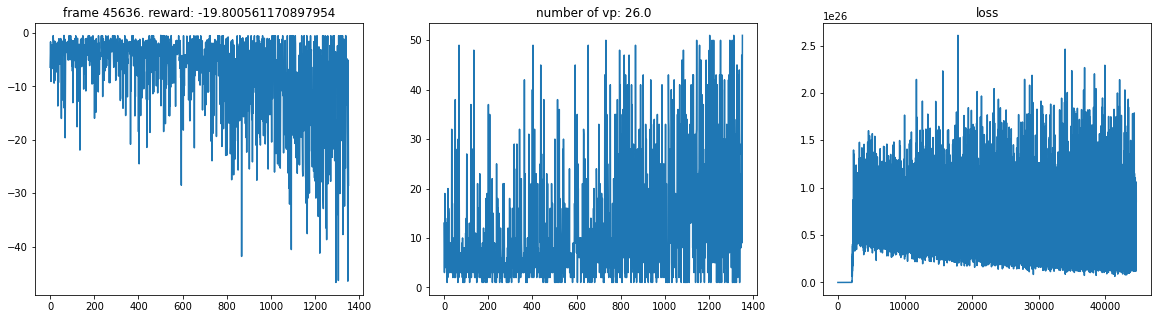

In [12]:
plot(frame_idx, all_rewards, all_nofs, losses)


In [13]:
def compute_metrics(env, agent_func, iter_cnt=10, max_iter=30):
    rewards, final_rewards, novp = [], [], []
    for _ in range(iter_cnt):
        state, action = env.reset()
        episode_reward = 0.0
        for t in range(max_iter):
            action = agent_func(state)
            state, reward, done, info = env.step(action)
            # print("REWARD: ", reward)
            env.render(action, state)
            episode_reward += reward

            if done:
                break

        final_reward = 0
        # final_reward = env.final_reward()
        # episode_reward += 1.0 / final_reward
        rewards.append(episode_reward)
        final_rewards.append(final_reward)
        novp.append(t + 1)
    return np.mean(rewards), np.mean(final_rewards), np.mean(novp)

In [ ]:
agent_func = lambda s : model.act(s, epsilon=0.0)
result = compute_metrics(env, agent_func)

Action:  60


/opt/conda/lib/python3.6/site-packages/traittypes/traittypes.py:101: UserWarning: Given trait value dtype "float64" does not match required type "float32". A coerced copy has been created.
  np.dtype(self.dtype).name))


Action:  60
Action:  60
Action:  60
Action:  60
Action:  60
Action:  60
Action:  60
Action:  60
Action:  60
Action:  60
Action:  60
Action:  60
Action:  60
Action:  60
Action:  60
Action:  60
Action:  60
Action:  60
Action:  60


In [60]:
print((6 * 256 * 256 * 8) / 1e9 * 3000, 'G')
print((10 * 512 * 512 * 8) / 1e9 * 5000, 'G')
print(1e6 * 10 * 512 * 512 * 4 / 2 ** 40, 'T')

9.437184 G
104.8576 G
9.5367431640625 T


In [ ]:
TODO Today:
    1. + check DQN with A, S as input -> send Sergey
    2. + Smaller depth_maps (6 * 256 * 256)
    3. + Illustrate reward as area + novp
    4. + Distributed Buffer
    5. + Buffer on hard disk (memmap)
    6. Floats to int
    7. GPU raycasting
    8. * Greedy algo
    9. * Voxels
    10. CNN different shapes input
    11. Preprocessed depth_maps
    
    10. Overfit experiments 
    11. ABC experiment
    
    12. Experiment radius = 1.0
    13. Experiments with smaller reward fine
    14. Experiment with different DQN-s
    15. ABC - write random model reading
    

Ideas:
    1. Add fine for same view_point
    
Big Experiments:
    1. Voxels
    2. PointNet
    3. Context (N first view_points)
    4. Meta-learning, подавать от простой к сложной детальке

In [15]:
difficult = [
    "00020107_b27a1602d1d44a3d89140ce4_007.obj",
    "00010095_5ae1ee45b583467fa009adc4_006.obj",
    "00010163_ccef4063b69f428e91b498c9_008.obj",
    "00010145_77759770d8cd48af80775d86_002.obj",
    "00010153_556de37e0a7447fcbfbdfd22_000.obj",
    "00010162_ccef4063b69f428e91b498c9_007.obj",
    "00020074_37170a1ba80747f1a1478985_000.obj",
    "00020077_bf146f0c5dee4199be920a21_000.obj",
    "00020080_7a689565e1e0481ca3ad4a6f_000.obj",
    "00010164_ccef4063b69f428e91b498c9_009.obj",
    "00010179_f91d806ac1e34ea1b14e23be_000.obj",
    "00020095_842a932142a9431784488344_000.obj",
    "00020097_e24ecc9c647f4bd1832bfb1d_000.obj",
    "00020106_b27a1602d1d44a3d89140ce4_006.obj",
    "00020141_b27a1602d1d44a3d89140ce4_041.obj",
    "00020155_b27a1602d1d44a3d89140ce4_055.obj",
    "00020186_b27a1602d1d44a3d89140ce4_086.obj",
    "00020202_b27a1602d1d44a3d89140ce4_102.obj",
    "00020203_b27a1602d1d44a3d89140ce4_103.obj",
    "00020213_1f65839d7f6c42bf8c2b3391_000.obj"]